In [1]:
import sys, os, ndreg, skimage
import matplotlib.pyplot as plt
from matplotlib import cm
from ndreg import preprocessor, registerer
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import missing_data_sim as mdmask

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
resolution = 50

In [11]:
rmt = BossRemote(cfg_file_or_dict='./intern.cfg')
atlas = ndreg.download_ara(rmt, resolution)
atlas_mask = preprocessor.create_mask(atlas, use_triangle=True)
width, height, depth = atlas.GetSize()
print(width,height,depth)

(264, 160, 228)


In [42]:
img = sitk.Image(atlas)
img_mask = preprocessor.create_mask(img, use_triangle=True)
img_mask.CopyInformation(img)
img = mdmask.mask_img(img, img_mask.SetPixel)

Exception: Incompatible dtype

In [7]:
annotations = ndreg.download_ara(rmt, resolution, type='annotation')

In [8]:
img_array = sitk.GetArrayFromImage(img)
atlas_array = sitk.GetArrayFromImage(atlas)

In [22]:
img_slice = img_array[:,50,:]
atlas_slice = atlas_array[:,50,:]

In [10]:
print(img_slice.shape)

(228, 264)


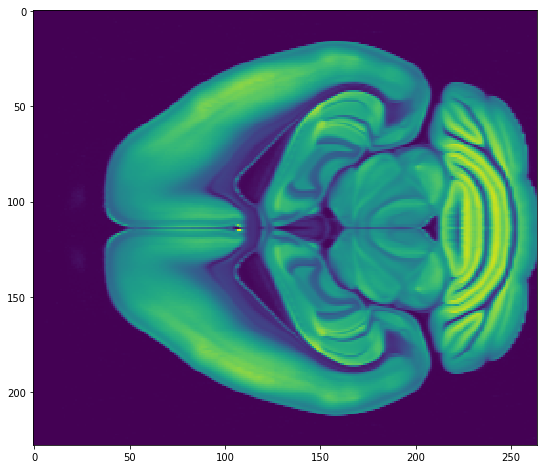

In [16]:
plt.imshow(img_slice)

In [35]:
img_slice_replacement = np.zeros((depth, width))
for i in range(depth-50):
    for j in range(width):
        img_slice_replacement[i+50,j] = img_slice[i,j]


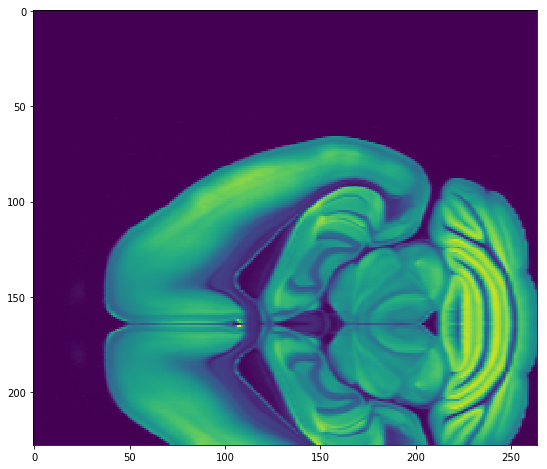

In [36]:
plt.imshow(img_slice_replacement)

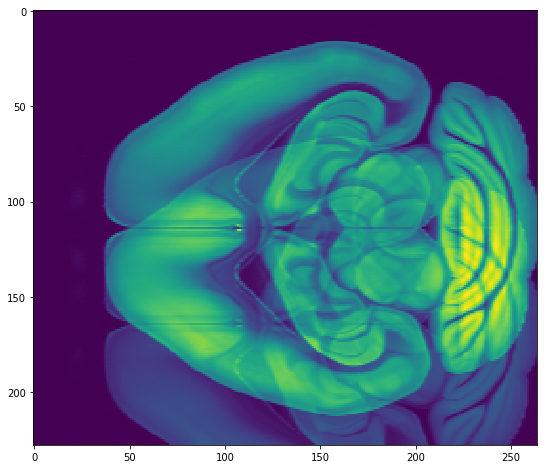

In [43]:
overlap = np.zeros((depth, width))
# overlap = np.zeros((depth, width,3))
for i in range(depth):
    for j in range(width):
#         grey = max(img_slice_replacement[i,j], atlas_slice[i,j])
        grey = img_slice_replacement[i,j]*0.3 + atlas_slice[i,j]*0.7
        overlap[i,j] = grey
#         overlap[i,j,:] = (grey, grey, grey)
plt.imshow(overlap)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


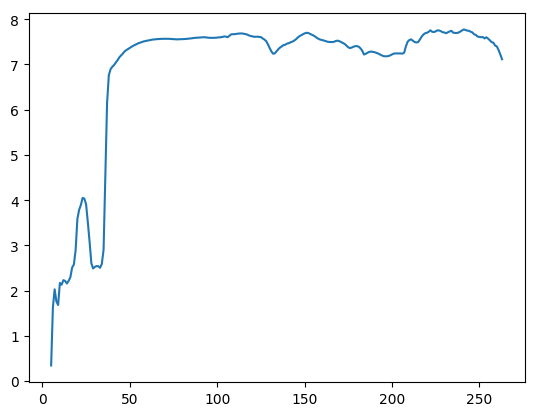

In [84]:
x_errors = []
for j in range(width):
    error = np.sqrt(np.sum(np.square(img_slice_replacement[:,j] - atlas_slice[:,j])))
    x_errors.append(error)
x_errors = np.log(np.array(x_errors))
# plt.plot(range(depth), y_errors)
plt.plot( range(width),x_errors )

In [ ]:
y_errors = []
for i in range(depth):
    error = np.sqrt(np.sum(np.square(img_slice_replacement[i,:] - atlas_slice[i,:])))
    y_errors.append(error)
y_errors = np.log(np.array(y_errors))
# plt.plot(range(depth), y_errors)
plt.plot( y_errors, range(depth))

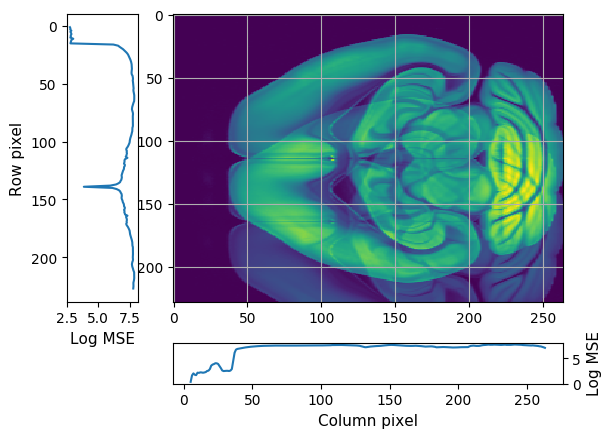

In [94]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(5, 5, wspace=0.5, hspace=1)

ax1 = plt.subplot(gs[:4, 0])
ax2 = plt.subplot(gs[:4, 1:])
ax3 = plt.subplot(gs[4, 1:])

ax1.plot(y_errors, range(depth))
ax1.invert_yaxis()
ax1.set_xlabel('Log MSE',fontsize=11)
ax1.set_ylabel('Row pixel', fontsize=11)
# ax1.set_title('Row-wise MSE', fontsize=12)

ax3.plot(range(width), x_errors)
ax3.set_xlabel('Column pixel',fontsize=11)
ax3.set_ylabel('Log MSE', fontsize=11)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()


ax2.imshow(overlap, aspect='auto')
ax2.grid(True)

In [101]:
def plot_mse(img1, img2, blend=0.2):
    height, width = img1.shape
    overlap = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            grey = img1[i,j]*blend + img2[i,j]*blend
            overlap[i,j] = grey
    
    x_errors = []
    for j in range(width):
        error = np.sqrt(np.sum(np.square(img1[:,j] - img2[:,j])))
        x_errors.append(error)
    x_errors = np.log(np.array(x_errors))
    
    y_errors = []
    for i in range(height):
        error = np.sqrt(np.sum(np.square(img1[i,:] - img2[i,:])))
        y_errors.append(error)
    y_errors = np.log(np.array(y_errors))
    
    gs = gridspec.GridSpec(5, 5, wspace=0.5, hspace=1)

    ax1 = plt.subplot(gs[:4, 0])
    ax2 = plt.subplot(gs[:4, 1:])
    ax3 = plt.subplot(gs[4, 1:])

    ax1.plot(y_errors, range(depth))
    ax1.invert_yaxis()
    ax1.set_xlabel('Log MSE',fontsize=11)
    ax1.set_ylabel('Row pixel', fontsize=11)

    ax3.plot(range(width), x_errors)
    ax3.set_xlabel('Column pixel',fontsize=11)
    ax3.set_ylabel('Log MSE', fontsize=11)
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()


    ax2.imshow(overlap, aspect='auto')
    ax2.grid(True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


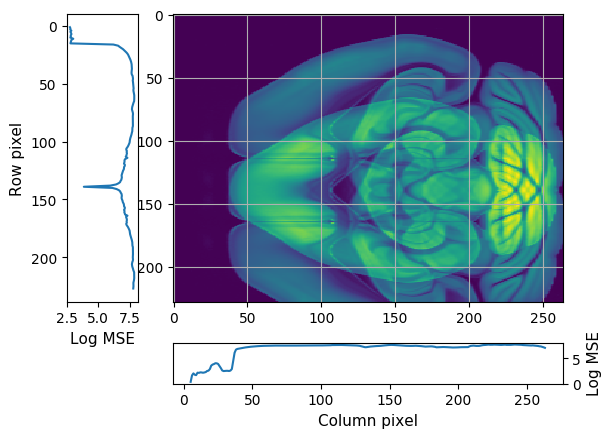

In [102]:
plot_mse(img_slice_replacement, atlas_slice)